# Rule Extraction and XAI metrics

In [1]:
import numpy as np
import pandas as pd
import os
import sys
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report
from lib.xai_auxiliary_rule_extraction import generateRuleHypercubes
from lib.xai_rule_metrics import (
    checkFidelity, 
    checkStability,
    checkDiversity
    )
from lib.xai_tools import plot_2D, loadDatasets

import warnings
warnings.filterwarnings("ignore")

### 1. Load Data & Get Anomalies

In [2]:
df_input, _, _ = loadDatasets(f_name = "sample-seismic")
numerical_cols = ["gdenergy", "gdpuls"]  # 2D
categorical_cols = []
df_input = (
    df_input[numerical_cols + categorical_cols + ['target_class']]
    .drop_duplicates(subset = numerical_cols + categorical_cols)
    .reset_index(drop=True)
            )
df_input.head()

,gdenergy,gdpuls,target_class
0,66,104,1
1,-58,15,1
2,279,91,1
3,75,8,1
4,-13,-8,1


In [3]:
# Train dataset
df_train = df_input.copy().drop(columns=['target_class'])

# Choose model & train it & get predictions

'''
# Example for IsolationForest
dct_params = {
    'n_estimators': 50, 
    'max_samples' : 'auto',
    'contamination': float(0.1),
    'max_features': 1.0
    }
clf = IsolationForest(**dct_params)
y_pred_train = clf.fit_predict(df_train)
'''

'''
# Example for LocalOutlierFactor
dct_params = {'novelty': True} # novelty must be always be True for getting the decision_function
clf = LocalOutlierFactor(**dct_params)
clf = clf.fit(df_train)
y_pred_train = clf.predict(df_train)
'''

# Example for OCSVM
dct_params = {'nu': 0.1, 'kernel': "rbf", 'gamma': 'scale'}
clf = OneClassSVM(**dct_params)
y_pred_train = clf.fit_predict(df_train)

In [4]:
dist = clf.decision_function(df_train)
df_anomalies = df_input.copy()
df_anomalies["predictions"] = y_pred_train
df_anomalies["dist"] = dist
df_anomalies["score"] = clf.decision_function(df_train)

df_anomalies.head()

,gdenergy,gdpuls,target_class,predictions,dist,score
0,66,104,1,-1,-0.057326,-0.057326
1,-58,15,1,-1,-0.515298,-0.515298
2,279,91,1,-1,-9.374869,-9.374869
3,75,8,1,1,0.422855,0.422855
4,-13,-8,1,1,0.765335,0.765335


In [8]:
# Choose XAI method
method = "SkopeRules"
# list_methods = ["DecisionTree", "RuleFit", "FRL", "SkopeRules", "brlg", "logrr"]

### 2. Get Rules as Hypercubes

In [9]:
## 1. Get Rules (Hypercube)
# Define hyperparams for the XAI model
model_params = {} # Leave an empty dict for default params

# Generate rules hypercubes
df_rules_inliers, df_rules_outliers = generateRuleHypercubes(
    df_anomalies = df_anomalies,
    numerical_cols = numerical_cols,
    categorical_cols = categorical_cols,
    method = method,
    simplify_rules = True, # True for pruning the rules and keep only rules not enclosed by bigger ones
    model_params = model_params,
)
df_rules_inliers.head()

Obtaining Rules using SkopeRules...
Checking inliers inside hypercubes...
Turning rules to hypercubes...
Iter 0/16
Iter 1/16
Iter 2/16
Iter 3/16
Iter 4/16
Iter 5/16
Iter 6/16
Iter 7/16
Iter 8/16
Iter 9/16
Iter 10/16
Iter 11/16
Iter 12/16
Iter 13/16
Iter 14/16
Iter 15/16
No more improvements... finishing up
Obtaining Rules using SkopeRules...
Checking inliers inside hypercubes...
Turning rules to hypercubes...
Iter 0/31
Iter 1/31
Iter 2/31
Iter 3/31
Iter 4/31
Iter 5/31
Iter 6/31
Iter 7/31
Iter 8/31
Iter 9/31
Iter 10/31
Iter 11/31
Iter 12/31
Iter 13/31
Iter 14/31
Iter 15/31
Iter 16/31
Iter 17/31
Iter 18/31
Iter 19/31
Iter 20/31
Iter 21/31
Iter 22/31
Iter 23/31
Iter 24/31
Iter 25/31
Iter 26/31
Iter 27/31
Iter 28/31
Iter 29/31
Iter 30/31
No more improvements... finishing up


,gdenergy_max,gdenergy_min,gdpuls_max,gdpuls_min,size_rules,rules_prediction
index,,,,,,
0,104.0,-90.5,100.0,-inf,3,1
1,103.5,-91.0,93.0,-inf,3,1
8,120.5,-90.0,100.0,-inf,3,1


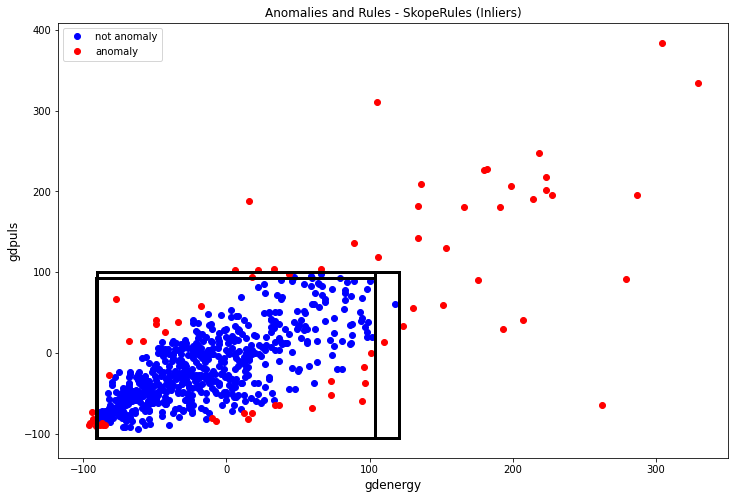

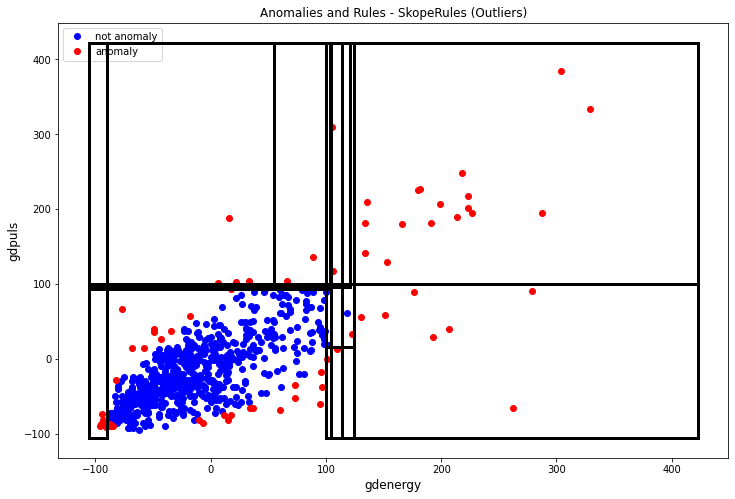

In [10]:
## 2. Plot Results [Only for 2D]
max_replace = df_input.max().max() + np.abs(df_input.max().max()) * 0.1
min_replace = df_input.min().min() - np.abs(df_input.min().min()) * 0.1
df_inliers_plot = (
    df_rules_inliers.copy()
    .replace(np.inf, max_replace)
    .replace(-np.inf, min_replace)
) 
df_outliers_plot = (
    df_rules_outliers.copy()
    .replace(np.inf, max_replace)
    .replace(-np.inf, min_replace)
)

plot_2D(df_inliers_plot, df_anomalies, title = method + ' (Inliers)')
plot_2D(df_outliers_plot, df_anomalies, title = method + ' (Outliers)')

### 3. XAI Metrics

In [11]:
# Precision (unsupervised model predictions vs ground truth)
target_names = ['outliers', 'inliers']
y_true = df_anomalies['target_class']
y_pred = df_anomalies['predictions']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    outliers       0.14      0.42      0.22        24
     inliers       0.98      0.91      0.94       671

    accuracy                           0.89       695
   macro avg       0.56      0.66      0.58       695
weighted avg       0.95      0.89      0.92       695



In [12]:
# Comprehensibility
n_rules_inliers = len(df_rules_inliers)
n_rules_outliers = len(df_rules_outliers)
mean_rule_size_inliers = df_rules_inliers['size_rules'].mean()
mean_rule_size_outliers = df_rules_outliers['size_rules'].mean()
print(f"N rules (inliers): {n_rules_inliers} | N rules (outliers): {n_rules_outliers}")
print(f"Mean rule size (inliers) {np.round(mean_rule_size_inliers, 2)}")
print(f"Mean rule size (outliers) {np.round(mean_rule_size_outliers, 2)}")

N rules (inliers): 3 | N rules (outliers): 11
Mean rule size (inliers) 3.0
Mean rule size (outliers) 2.09


In [13]:
# Fidelity/Representativeness/Focus on Abnormal
df_rules_inliers, df_rules_outliers, df_anomalies = checkFidelity(
    df_anomalies,
    df_rules_inliers,
    df_rules_outliers,
    numerical_cols, 
    categorical_cols
    )

Getting rule predictions...
Iter 0/695
Iter 500/695

Getting rule coverage...
Iter 0/695
Iter 500/695


In [14]:
# Stability
df_rules_inliers = checkStability(
    df_anomalies, 
    df_rules_inliers, 
    clf,
    numerical_cols,
    categorical_cols,
    using_inliers = True
    )
df_rules_outliers = checkStability(
    df_anomalies,
    df_rules_outliers, 
    clf,
    numerical_cols, 
    categorical_cols,
    using_inliers = False
    )
    
df_rules_inliers.head()

,gdenergy_max,gdenergy_min,gdpuls_max,gdpuls_min,size_rules,rules_prediction,n_inliers_included,n_outliers_included,n_inliers,n_inliers_p0,n_inliers_p1,precision_rules,recall_rules,f1_rules,precision_rules_abnormal,recall_rules_abnormal,f1_rules_abnormal,stability_score
index,,,,,,,,,,,,,,,,,,
0,104.0,-90.5,100.0,-inf,3,1,625,29,626,626,0,0.952816,1.0,0.955396,0.076923,1.0,0.727273,0.8
1,103.5,-91.0,93.0,-inf,3,1,622,28,626,626,0,0.952816,1.0,0.955396,0.076923,1.0,0.727273,0.8
8,120.5,-90.0,100.0,-inf,3,1,626,30,626,626,0,0.952816,1.0,0.955396,0.076923,1.0,0.727273,0.8


In [16]:
# Diversity
df_rules_inliers, _ = checkDiversity(
    df_rules_inliers, 
    numerical_cols, 
    categorical_cols
    )
df_rules_outliers, _ = checkDiversity(
    df_rules_outliers, 
    numerical_cols, 
    categorical_cols
    )
df_rules_inliers.head()

Iter 1/1
Iter 1/1


,gdenergy_max,gdenergy_min,gdpuls_max,gdpuls_min,size_rules,rules_prediction,n_inliers_included,n_outliers_included,n_inliers,n_inliers_p0,n_inliers_p1,precision_rules,recall_rules,f1_rules,precision_rules_abnormal,recall_rules_abnormal,f1_rules_abnormal,stability_score,diversity_score
index,,,,,,,,,,,,,,,,,,,
0,104.0,-90.5,100.0,-inf,3,1,625,29,626,626,0,0.952816,1.0,0.955396,0.076923,1.0,0.727273,0.8,0.079127
1,103.5,-91.0,93.0,-inf,3,1,622,28,626,626,0,0.952816,1.0,0.955396,0.076923,1.0,0.727273,0.8,0.079127
8,120.5,-90.0,100.0,-inf,3,1,626,30,626,626,0,0.952816,1.0,0.955396,0.076923,1.0,0.727273,0.8,0.079127
